# Generate bbox crops from ground truth

In [ ]:
from fastai.vision.all import *

Download the dataset from https://www.mapillary.com/dataset/trafficsign (unfortunatelly manually – you need to provide your name and accept the license) and unpack them somewhere (see `path` below).

We will need these files:
- mtsd_fully_annotated_annotation.zip
- mtsd_fully_annotated_images.test.zip
- mtsd_fully_annotated_images.train.0.zip
- mtsd_fully_annotated_images.train.1.zip
- mtsd_fully_annotated_images.train.2.zip
- mtsd_fully_annotated_images.val.zip

In [ ]:
# Mapillary dataset path:
path = Path('.')
# Where to put the cropped traffic signs (in separate subfolders for each label):
outpath = Path('yolo-bbox-crops-aspects')

Let's do a quick sanity check on the unpacked data:

In [ ]:
if not (path/'mtsd_v2_fully_annotated/splits/val.txt').exists():
    raise IOError(f"Missing Mapillary annotations, please unpack them to: {path.absolute()}")

In [ ]:
if not (path/'images/--48MAqc82-bZdgGpaiexA.jpg').exists():
    raise IOError(f"Missing Mapillary images, please unpack them to: {path.absolute()}")

In [ ]:
with open(path/'mtsd_v2_fully_annotated/splits/train.txt', 'r') as f:
    trnidx = [x.strip() for x in f.readlines()]
with open(path/'mtsd_v2_fully_annotated/splits/val.txt', 'r') as f:
    validx = [x.strip() for x in f.readlines()]

## Loading the bounding box annotations

In [ ]:
def read_mapillary_annotation(idx):
    with open(Path('mtsd_v2_fully_annotated/annotations')/(idx+'.json')) as fd:
        anno = json.load(fd)
    
    w,h = float(anno['width']), float(anno['height'])
        
    labels = []
    bboxes = []
    
    for obj in anno['objects']:
        bbox = obj['bbox']
        bboxes.append([bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']])
        labels.append(obj['label'])
    return dict(
        idx = idx, w = w, h = h, pano = anno['ispano'],
        labels = np.array(labels),
        bboxes = np.array(bboxes),
    )

In [ ]:
read_mapillary_annotation(trnidx[0])

{'idx': 'aVuSPwmImhhe01o_hJm7IA',
 'w': 3264.0,
 'h': 2448.0,
 'pano': False,
 'labels': array(['warning--traffic-merges-right--g1',
        'warning--added-lane-right--g1'], dtype='<U33'),
 'bboxes': array([[1529.203125  , 1829.42578125, 1602.515625  , 1904.1328125 ],
        [2209.734375  , 1893.97265625, 2259.140625  , 1942.98046875]])}

Calculating width and height – we'll need it to get the aspect ratio of each sign. We are resizing (squishing) every sign into a 40x40 pixels square so remembering the original aspect ratio might be helpful.

In [ ]:
bboxes = read_mapillary_annotation(trnidx[0])['bboxes']

In [ ]:
wh = bboxes[:,2:] - bboxes[:,:2]
wh

array([[73.3125    , 74.70703125],
       [49.40625   , 49.0078125 ]])

In [ ]:
def create_crops(annotation, output_size=(40,40)):
    aspects = {}
    img = Image.open(f"images/{annotation['idx']}.jpg")
    for i, (bbox, label) in enumerate(zip(annotation['bboxes'], annotation['labels'])):
        try:
            wh = bbox[2:] - bbox[:2]
            size = np.exp(np.log(wh).mean(-1))
            !mkdir -p {outpath}/{label}
            name = f"{label}/{annotation['idx']}-{i}.jpg"
            aspects[name] = wh[0]/wh[1]
            img.crop(bbox).resize(output_size).save(f"{outpath}/{name}")
        except:
            print(f"Skipping {annotation['idx']}-{i} / {label}")
    return aspects

First let's verify it works for just a couple of images:

In [ ]:
!rm -r {outpath}

rm: cannot remove 'yolo-bbox-crops-aspects': No such file or directory


In [ ]:
aspects = {k:v for idx in trnidx[:5] for k,v in create_crops(read_mapillary_annotation(idx)).items()}
aspects

{'warning--traffic-merges-right--g1/aVuSPwmImhhe01o_hJm7IA-0.jpg': 0.9813333333333333,
 'warning--added-lane-right--g1/aVuSPwmImhhe01o_hJm7IA-1.jpg': 1.008130081300813,
 'warning--playground--g1/cydOiChUMzcddBqofGmlYQ-0.jpg': 0.9863013698630136,
 'other-sign/iMeyPoRIiG_jtafHEXkNuA-0.jpg': 0.96045197740113,
 'other-sign/iMeyPoRIiG_jtafHEXkNuA-1.jpg': 0.6654252017380509,
 'other-sign/yBt7KOsmqzNZr9dK9FOdAA-0.jpg': 1.7851239669421488,
 'other-sign/yBt7KOsmqzNZr9dK9FOdAA-1.jpg': 2.3655913978494625,
 'other-sign/lWhwLkHcnSv7KS9IvK_4pw-0.jpg': 1.2941176470588236,
 'other-sign/lWhwLkHcnSv7KS9IvK_4pw-1.jpg': 1.4054054054054055,
 'other-sign/lWhwLkHcnSv7KS9IvK_4pw-2.jpg': 1.0747782002534854}

In [ ]:
!ls -lR {outpath}

yolo-bbox-crops-aspects:
total 16
drwxrwxr-x 2 jpc jpc 4096 Jul 20 18:17 other-sign
drwxrwxr-x 2 jpc jpc 4096 Jul 20 18:17 warning--added-lane-right--g1
drwxrwxr-x 2 jpc jpc 4096 Jul 20 18:17 warning--playground--g1
drwxrwxr-x 2 jpc jpc 4096 Jul 20 18:17 warning--traffic-merges-right--g1

yolo-bbox-crops-aspects/other-sign:
total 28
-rw-rw-r-- 1 jpc jpc  878 Jul 20 18:17 iMeyPoRIiG_jtafHEXkNuA-0.jpg
-rw-rw-r-- 1 jpc jpc  966 Jul 20 18:17 iMeyPoRIiG_jtafHEXkNuA-1.jpg
-rw-rw-r-- 1 jpc jpc 1076 Jul 20 18:17 lWhwLkHcnSv7KS9IvK_4pw-0.jpg
-rw-rw-r-- 1 jpc jpc 1007 Jul 20 18:17 lWhwLkHcnSv7KS9IvK_4pw-1.jpg
-rw-rw-r-- 1 jpc jpc 1125 Jul 20 18:17 lWhwLkHcnSv7KS9IvK_4pw-2.jpg
-rw-rw-r-- 1 jpc jpc 1051 Jul 20 18:17 yBt7KOsmqzNZr9dK9FOdAA-0.jpg
-rw-rw-r-- 1 jpc jpc  989 Jul 20 18:17 yBt7KOsmqzNZr9dK9FOdAA-1.jpg

yolo-bbox-crops-aspects/warning--added-lane-right--g1:
total 4
-rw-rw-r-- 1 jpc jpc 1189 Jul 20 18:17 aVuSPwmImhhe01o_hJm7IA-1.jpg

yolo-bbox-crops-aspects/warning--playground--g1:
total 4

warning--traffic-merges-right--g1/aVuSPwmImhhe01o_hJm7IA-0.jpg
0.9813333333333333


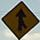

In [ ]:
crop = list(aspects.keys())[0]
print(crop)
print(aspects[crop])
Image.open(f"{outpath}/{crop}")

## Generating all the cropped signs (in parallel)

In [ ]:
!rm -r {outpath}

In [ ]:
def make_crops(idx): return create_crops(read_mapillary_annotation(idx))

In [ ]:
trn_aspects = parallel(make_crops, trnidx, progress=True)

/tmp/ipykernel_19088/1987497340.py:7: RuntimeWarning: invalid value encountered in log
  size = np.exp(np.log(wh).mean(-1))


Skipping dtjhRwZcYld3CdbIFmQJaA-4 / other-sign


/tmp/ipykernel_19088/1987497340.py:7: RuntimeWarning: invalid value encountered in log
  size = np.exp(np.log(wh).mean(-1))


Skipping OENb8BfFyAocFzHHM4Mehg-1 / regulatory--no-entry--g1


In [ ]:
val_aspects = parallel(make_crops, validx, progress=True)

/tmp/ipykernel_19088/1987497340.py:7: RuntimeWarning: invalid value encountered in log
  size = np.exp(np.log(wh).mean(-1))


Skipping mw82Ix9zLKMBsOBqASEiDQ-8 / other-sign


In [ ]:
all_aspects = {k:v for d in trn_aspects+val_aspects for k,v in d.items()}
len(all_aspects)

206386

In [ ]:
pd.Series(all_aspects.values()).describe()

count    206386.000000
mean          1.273720
std           0.880521
min         -34.660870
25%           0.838095
50%           1.011570
75%           1.333333
max          17.502110
dtype: float64

<AxesSubplot:>

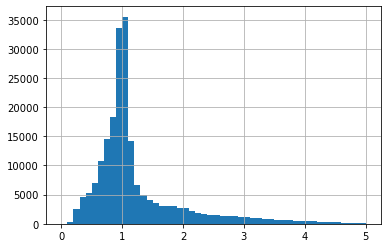

In [ ]:
pd.Series(all_aspects.values()).hist(range=(0,5), bins=50)

In [ ]:
pd.Series(all_aspects).to_csv('aspect-ratios.csv')